In [11]:
import os
import pickle

import astropy.table as at
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb
from scipy.stats import beta
from scipy.special import loggamma, logsumexp

import pymc3 as pm
import theano.tensor as tt
import theano
import exoplanet as xo

from hq.config import Config
from hq.data import get_rvdata

from helpers import ms_path, rg_path, fast_m2_min, fast_mf, load_samples

In [3]:
c = Config.from_run_name('dr16-random')

In [4]:
meta = at.QTable.read('../catalogs/dr16_gaia_starhorse_metadata.fits')
meta = at.Table(meta[np.isfinite(meta['mass'])], masked=False).filled()
# meta = at.join(meta, allstar, keys='APOGEE_ID')

INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [5]:
X = np.stack((meta['TEFF'], meta['LOGG'])).T
ms_mask = ms_path.contains_points(X)
rg_mask = rg_path.contains_points(X)
ms_mask.sum(), rg_mask.sum()

(58418, 134475)

In [6]:
all_mask = (ms_mask & 
            (meta['TEFF'] > 4000) & (meta['TEFF'] < 7000) &
            (meta['M_H'] > -2) & (meta['M_H'] < 0.4))
all_mask.sum()

53790

In [7]:
(all_mask & meta['mcmc_success']).sum()

815

In [8]:
meta_bin = meta[all_mask]
len(meta_bin)

53790

In [9]:
samples_nk = at.Table()
samples_nk['APOGEE_ID'] = np.empty(len(meta_bin), 
                                   dtype='U{}'.format(len(meta['APOGEE_ID'][0])))

for name in ['P', 'e', 'K', 'm1', 'm2sini']:
    samples_nk[name] = np.full((len(meta_bin), c.requested_samples_per_star), np.nan)

In [10]:
if not os.path.exists('samples_nk.pkl'):
    for n, row in enumerate(tqdm(meta_bin)):
        samples_nk['APOGEE_ID'][n] = row['APOGEE_ID']

        samples = load_samples(c, row)
        _, idx = np.unique(samples['e'], return_index=True)
        samples = samples[idx]

        K_n = len(samples)
        m1s = np.random.normal(row['mass'], row['mass_err'], 
                               size=min(c.requested_samples_per_star, K_n))
        mfs = fast_mf(samples['P'], samples['K'], samples['e'])
        m2min = fast_m2_min(m1s, mfs.to_value(u.Msun))

        for name in ['P', 'e', 'K']:
            samples_nk[name][n, :K_n] = samples[name].value

        samples_nk['m1'][n, :K_n] = m1s[:K_n]
        samples_nk['m2sini'][n, :K_n] = m2min[:K_n]

    with open('samples_nk.pkl', 'wb') as f:
        pickle.dump(samples_nk, f)

else:
    with open('samples_nk.pkl', 'rb') as f:
        samples_nk = pickle.load(f)

In [15]:
P_min = 100
K_min = 1

In [16]:
e_nk = samples_nk['e'].copy()

skip_mask = ((np.percentile(samples_nk['K'], 5, axis=1) < K_min)[:, None] 
             | (samples_nk['P'] < P_min))
e_nk[skip_mask] = np.nan

ln_prior0 = beta.logpdf(e_nk, 0.867, 3.03)

K_n = np.isfinite(e_nk).sum(axis=1)

# Weights:
b_n = np.ones_like(e_nk)
b_n[~np.isfinite(e_nk)] = 0.

In [91]:
Kn_mask = K_n > 128
# Kn_mask[1000:] = False
print(Kn_mask.sum())

8599


In [92]:
observed = {
    'e_nk': e_nk[Kn_mask], 
    'K_n': K_n[Kn_mask],
    'ln_b_n': np.log(b_n[Kn_mask]),
    'ln_p0': ln_prior0[Kn_mask]
}

for k in observed:
    observed[k][np.isnan(observed[k])] = -9999.

In [93]:
def beta_logpdf(x, a, b):
    denom = loggamma(a) + loggamma(b)
    res = loggamma(a+b) + (a-1)*np.log(x) + (b-1)*np.log(1-x) - denom
    return res.real

def ln_likelihood(p, e_nk, K_n, ln_b_n, ln_p0):
    a, b = p    
    new_ln_prob = beta_logpdf(e_nk, a, b)
    ll = logsumexp(new_ln_prob - ln_p0, b=np.exp(ln_b_n), axis=1) - np.log(K_n)
    return ll

def neg_ln_likelihood(p):
    return -ln_likelihood(p, **observed).sum()

In [94]:
from scipy.optimize import minimize

In [95]:
neg_ln_likelihood([1.6, 1.6])

-297.2551374179813

In [96]:
res = minimize(neg_ln_likelihood, 
               x0=[1.6, 1.9],
               bounds=[(0.1, 10), (0.1, 10)])

In [97]:
res

      fun: -322.10497293229577
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.38742359e-04, 9.09494702e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 6
   status: 0
  success: True
        x: array([1.74928924, 2.00795687])

(-0.1, 10)

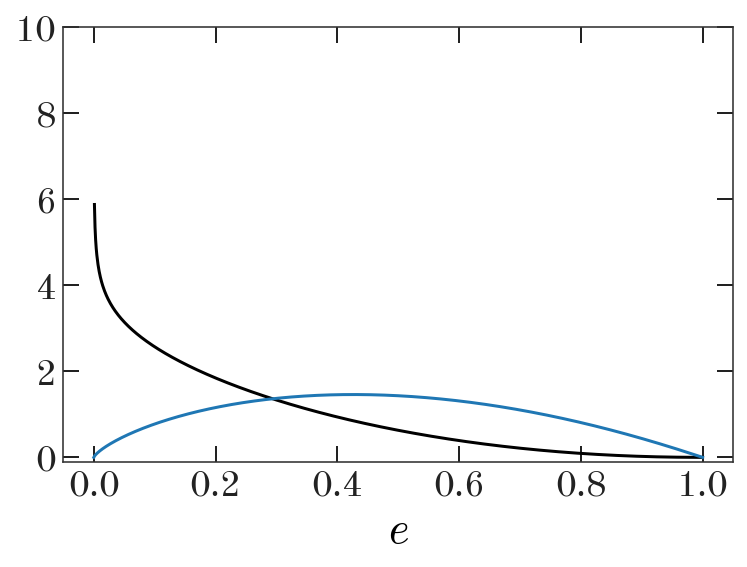

In [98]:
e_grid = np.linspace(0, 1, 1024)
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, 0.867, 3.03)), marker='')
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, *res.x)), 
         alpha=1.0, marker='', color='tab:blue')
plt.xlabel('$e$')
plt.gcf().set_facecolor('w')
plt.ylim(-0.1, 10)

In [99]:
# def logp(e, e_nk, K_n, ln_b_n, ln_p0):
#     new_ln_prob = e.distribution.logp(e_nk)
#     ll = pm.logsumexp(new_ln_prob - ln_p0 + ln_b_n, axis=1) - tt.log(K_n)
#     return ll.sum()

def logp(a, b, e_nk, K_n, ln_b_n, ln_p0):
    new_ln_prob = pm.Beta.dist(a, b).logp(e_nk)
    ll = pm.logsumexp(new_ln_prob - ln_p0 + ln_b_n, axis=1) - tt.log(K_n)
    return ll.sum()

In [100]:
with pm.Model() as model:
    a = pm.Uniform('a', 0.1, 10)
    b = pm.Uniform('b', 0.1, 10)
    # e_n = pm.Beta('e', a, b)
    
    # test = pm.DensityDist('test', logp, observed={'e': e_n , **observed})
    test = pm.DensityDist('test', logp, observed={'a': a, 'b': b, **observed})
    print(model.logp(model.test_point))
    
    trace = pm.sample(tune=100, draws=2000, chains=2, 
                      start={'a': res.x[0], 'b': res.x[1]})
#                       step=xo.get_dense_nuts_step())

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


1909366.9595466412


Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4200/4200 [2:24:48<00:00,  2.07s/draws]  
The acceptance probability does not match the target. It is 0.925019338018234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9259709818604064, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [107]:
len(trace)

2000

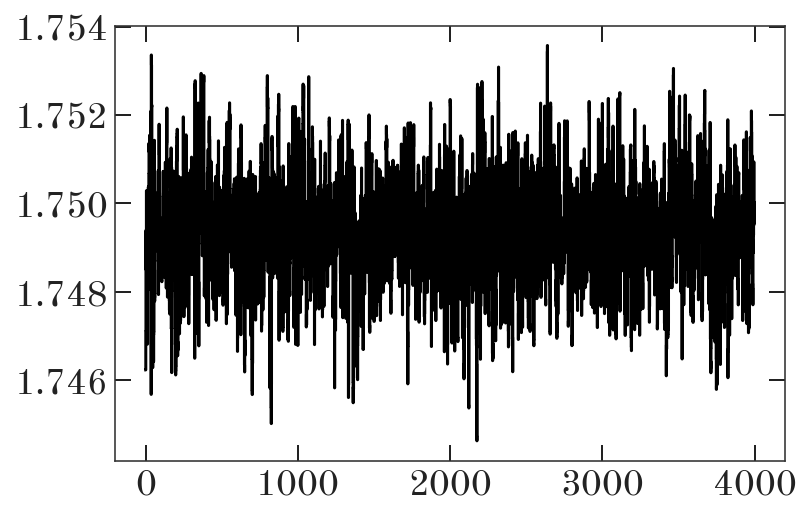

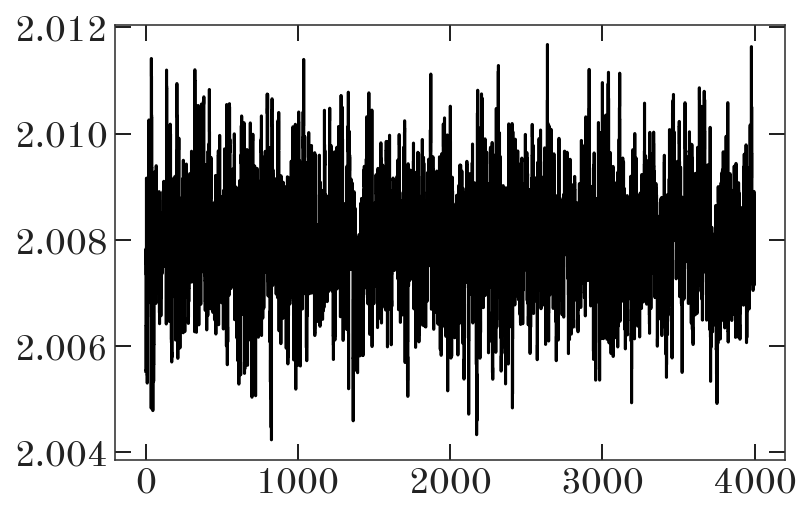

In [113]:
for name in ['a', 'b']:
    plt.figure()
    plt.plot(trace.get_values(name), marker='', drawstyle='steps-mid')

(-0.1, 6)

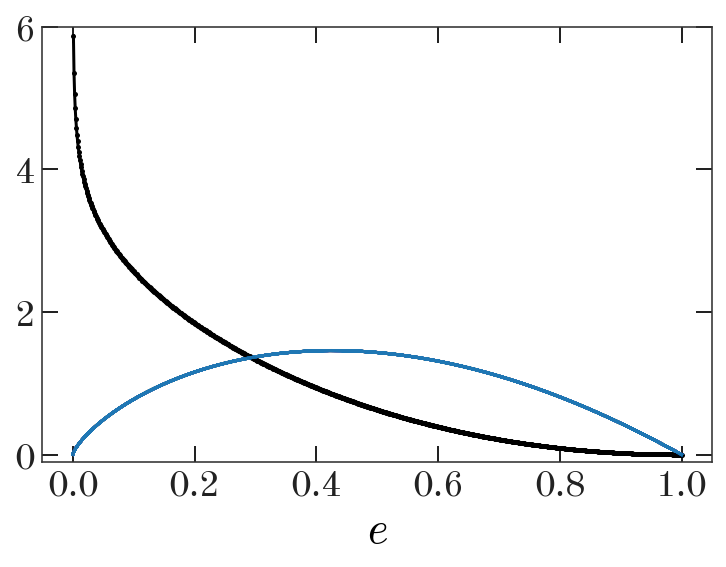

In [115]:
e_grid = np.linspace(0, 1, 1024)
plt.plot(e_grid, np.exp(beta_logpdf(e_grid, 0.867, 3.03)))

for a, b in zip(np.random.choice(trace.get_values('a', thin=10), size=128, replace=False),
                np.random.choice(trace.get_values('b', thin=10), size=128, replace=False)):
    plt.plot(e_grid, np.exp(beta_logpdf(e_grid, a, b)), 
                alpha=0.1, marker='', color='tab:blue')

plt.xlabel('$e$')
plt.gcf().set_facecolor('w')
plt.ylim(-0.1, 6)

In [122]:
for name in ['a', 'b']:
    vals = trace.get_values(name, thin=10)
    print(f"{name}: {np.mean(vals):.3f} +/- {np.std(vals):.3f}")

a: 1.749 +/- 0.001
b: 2.008 +/- 0.001


In [125]:
t = at.Table()
for name in ['a', 'b']:
    t[name] = trace.get_values(name, thin=4)
t.write('../data/ecc_ab_samples.csv', overwrite=True)

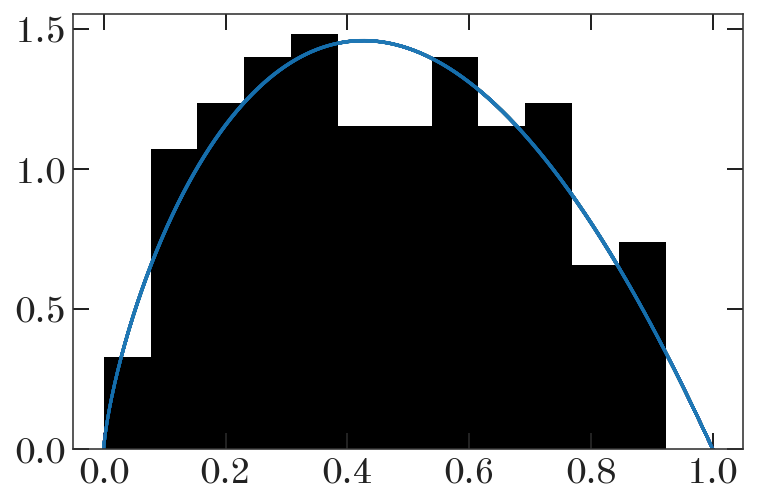

In [136]:
plt.hist(meta_bin[meta_bin['mcmc_success'] & ((512-np.sum(skip_mask, axis=1)) > 128)]['MAP_e'], 
         bins=np.linspace(0, 1, 14), density=True);

for a, b in zip(np.random.choice(trace.get_values('a', thin=10), size=128, replace=False),
                np.random.choice(trace.get_values('b', thin=10), size=128, replace=False)):
    plt.plot(e_grid, np.exp(beta_logpdf(e_grid, a, b)), 
                alpha=0.1, marker='', color='tab:blue')